## Pyspark + Prophet 예측

- jupyter/pyspark:python3.8.8에서 작성
- 데이터 출처 (캐글 링크 | https://www.kaggle.com/datasets/uciml/electric-power-consumption-data-set)

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import pandas_udf, PandasUDFType, sum, max, col, concat, lit
import pyspark.sql
from pyspark.sql.functions import *	
import pandas as pd
from fbprophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Importing plotly failed. Interactive plots will not work.


In [2]:
spark = (
    SparkSession.builder
    .master('local')
    .appName('SparkML')
    .config('spark.sql.execution.arrow.enable', 'true')
    .getOrCreate()
)
sc = spark.sparkContext
sc.setLogLevel('INFO')

In [3]:
df = spark.read.csv('household_power_consumption.csv', header = True, inferSchema=True)
df.show()
df.printSchema()

+-------------------+-------------------+---------------------+-------+----------------+--------------+--------------+--------------+--------------+
|           datetime|Global_active_power|Global_reactive_power|Voltage|Global_intensity|Sub_metering_1|Sub_metering_2|Sub_metering_3|sub_metering_4|
+-------------------+-------------------+---------------------+-------+----------------+--------------+--------------+--------------+--------------+
|2006-12-16 17:24:00|              4.216|                0.418| 234.84|            18.4|           0.0|           1.0|          17.0|      52.26667|
|2006-12-16 17:25:00|               5.36|                0.436| 233.63|            23.0|           0.0|           1.0|          16.0|     72.333336|
|2006-12-16 17:26:00|              5.374|                0.498| 233.29|            23.0|           0.0|           2.0|          17.0|     70.566666|
|2006-12-16 17:27:00|              5.388|                0.502| 233.74|            23.0|           0.0|   

In [4]:
df = df.withColumn('datetime', to_date('datetime'))
df.printSchema()

root
 |-- datetime: date (nullable = true)
 |-- Global_active_power: double (nullable = true)
 |-- Global_reactive_power: double (nullable = true)
 |-- Voltage: double (nullable = true)
 |-- Global_intensity: double (nullable = true)
 |-- Sub_metering_1: double (nullable = true)
 |-- Sub_metering_2: double (nullable = true)
 |-- Sub_metering_3: double (nullable = true)
 |-- sub_metering_4: double (nullable = true)



In [5]:
# 날짜 별 global_active_power 출력
df = (
    df
    .groupby('datetime')
    .agg({
        'Global_active_power': 'sum'
    })
)

In [6]:
df = df.sort('datetime')
df.show()

+----------+------------------------+
|  datetime|sum(Global_active_power)|
+----------+------------------------+
|2006-12-16|      1209.1760000000006|
|2006-12-17|                 3390.46|
|2006-12-18|      2203.8259999999964|
|2006-12-19|      1666.1940000000006|
|2006-12-20|       2225.747999999999|
|2006-12-21|      1723.2879999999993|
|2006-12-22|      2341.3379999999993|
|2006-12-23|       4773.385999999998|
|2006-12-24|       2550.012000000007|
|2006-12-25|      2743.1200000000053|
|2006-12-26|                 3934.11|
|2006-12-27|      1528.7600000000004|
|2006-12-28|                2072.638|
|2006-12-29|      3174.3919999999966|
|2006-12-30|       2796.108000000001|
|2006-12-31|      3494.1959999999995|
|2007-01-01|       2749.004000000016|
|2007-01-02|      1269.2360000000006|
|2007-01-03|      1014.0540000000005|
|2007-01-04|      3259.4119999999907|
+----------+------------------------+
only showing top 20 rows



In [7]:
# 이름 재정의
df = df.withColumnRenamed('sum(Global_active_power)', 'Global_active_power')
df.show()

+----------+-------------------+
|  datetime|Global_active_power|
+----------+-------------------+
|2006-12-16| 1209.1760000000006|
|2006-12-17|            3390.46|
|2006-12-18| 2203.8259999999964|
|2006-12-19| 1666.1940000000006|
|2006-12-20|  2225.747999999999|
|2006-12-21| 1723.2879999999993|
|2006-12-22| 2341.3379999999993|
|2006-12-23|  4773.385999999998|
|2006-12-24|  2550.012000000007|
|2006-12-25| 2743.1200000000053|
|2006-12-26|            3934.11|
|2006-12-27| 1528.7600000000004|
|2006-12-28|           2072.638|
|2006-12-29| 3174.3919999999966|
|2006-12-30|  2796.108000000001|
|2006-12-31| 3494.1959999999995|
|2007-01-01|  2749.004000000016|
|2007-01-02| 1269.2360000000006|
|2007-01-03| 1014.0540000000005|
|2007-01-04| 3259.4119999999907|
+----------+-------------------+
only showing top 20 rows



In [8]:
# null 값 확인
df.select(*(
    sum(col(c).isNull().cast('int')).alias(c) for c in df.columns
)).show()

+--------+-------------------+
|datetime|Global_active_power|
+--------+-------------------+
|       0|                  0|
+--------+-------------------+



In [9]:
# schema 정의
schema = StructType([
    StructField('ds', DateType(), True),
    StructField('yhat', DoubleType(), True),
#     StructField('Global_reactive_power', DoubleType(), True),
#     StructField('Voltage', DoubleType(), True),
#     StructField('Global_intensity', DoubleType(), True),
#     StructField('Sub_metering_1', DoubleType(), True),
#     StructField('Sub_metering_2', DoubleType(), True),
#     StructField('Sub_metering_3', DoubleType(), True),
#     StructField('sub_metering_4', DoubleType(), True),
])

In [10]:
# 포함하지 않을 날짜 정의
def getHoliday():
    yeonyu = pd.DataFrame({
        'holiday':'yeonyu',
        'ds': pd.to_datetime(['2006-12-16', '2006-12-25', '2006-12-30']),
        'lower_window': 0,
        'upper_window': 1
    })
    vac = pd.DataFrame({
        'holiday':'vac',
        'ds': pd.to_datetime(['2006-12-20', '2007-12-25', '2008-12-30']),
        'lower_window': 0,
        'upper_window': 1
    })
    holiday = pd.concat((yeonyu, vac))
    return holiday

In [11]:
# train test 분리 prophet model 돌리기 
@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def train_fit_map(df):
    def train_fit_prophet(df, cutoff):
        df["dt"] = pd.to_datetime(df["dt"])
        train_ts = (df
                    .query('dt <= @cutoff')
                    .rename(columns = {'dt':'ds', 'Global_active_power':'y'})
                    .assign(ds = lambda x: pd.to_datetime(x['ds']))
                    .sort_values('ds')
                   )
        test_ts = (df
                   .query('dt > @cutoff')
                   .rename(columns = {'dt':'ds', 'Global_active_power':'y'})
                   .drop('y', axis=1)
                   .sort_values('ds')
                   .assign(ds = lambda x: pd.to_datetime(x['ds']))
                  )
        holidays = getHoliday()
        m = Prophet(yearly_seasonality=True,
                    weekly_seasonality=True,
                    daily_seasonality=True,
                    holidays=holidays)
        m.fit(train_ts)
        ts_hat = (m.predict(test_ts)[['ds', 'yhat']]
                 .assign(ds = lambda x: pd.to_datetime(x['ds']))
                 ).merge(test_ts, on = ['ds'], how = 'left')
        return pd.DataFrame(ts_hat, columns = schema.fieldNames())
    return train_fit_prophet(df, cutoff)

In [12]:
cutoff_index = int(df.count() * 0.75)
df = df.withColumn('datetime', col('datetime').cast('String'))
cutoff = df.select('datetime').collect()[cutoff_index][0]
cutoff

'2009-12-01'

In [13]:
df = df.withColumnRenamed('datetime', 'dt')

In [14]:
global_prediction = (df
                     .groupBy()
                     .apply(train_fit_map))

/usr/local/spark/python/pyspark/sql/pandas/group_ops.py:81: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [15]:
# 모델 예측 결과
global_prediction.show(20)

+----------+------------------+
|        ds|              yhat|
+----------+------------------+
|2009-12-02|2013.0072510130535|
|2009-12-03|1826.0035000376397|
|2009-12-04|1944.4264796494003|
|2009-12-05| 2241.565975240988|
|2009-12-06| 2198.620180732972|
|2009-12-07|1823.2991312273134|
|2009-12-08| 1948.823449120789|
|2009-12-09|1961.8823631516948|
|2009-12-10|1788.5308196172155|
|2009-12-11|1922.2696607216133|
|2009-12-12|2235.8665600643203|
|2009-12-13| 2209.972330075237|
|2009-12-14|1851.7399853246163|
|2009-12-15|1993.8393177574435|
|2009-12-16|2022.4305029197494|
|2009-12-17| 1863.076123177765|
|2009-12-18|2008.8351688835064|
|2009-12-19|  2332.09632415064|
|2009-12-20| 2313.204810015334|
|2009-12-21|1959.0898776468698|
+----------+------------------+
only showing top 20 rows



In [16]:
# MAE 진행을 위한 test_df 값 정리 
test_df = (
    df
    .select(col('dt').alias('ds'), col('Global_active_power').alias('y_test'))
    .where('dt > "{}"'.format(cutoff))
)
test_df.show()

+----------+------------------+
|        ds|            y_test|
+----------+------------------+
|2009-12-02| 2345.667999999997|
|2009-12-03|1479.6880000000006|
|2009-12-04|          1711.294|
|2009-12-05|          2351.762|
|2009-12-06|2378.2879999999986|
|2009-12-07|          1742.638|
|2009-12-08|2006.8840000000037|
|2009-12-09|1802.3559999999977|
|2009-12-10|2057.2560000000035|
|2009-12-11|1784.4619999999998|
|2009-12-12|1816.3799999999999|
|2009-12-13|2138.8139999999953|
|2009-12-14| 1794.862000000001|
|2009-12-15|1940.1160000000034|
|2009-12-16|1394.8740000000007|
|2009-12-17|1717.1819999999968|
|2009-12-18|1744.7059999999983|
|2009-12-19| 2204.334000000001|
|2009-12-20|1144.1659999999993|
|2009-12-21|2034.9659999999997|
+----------+------------------+
only showing top 20 rows



In [17]:
# MAE 오차 값 구하기
pred_test_df = global_prediction.join(test_df, on='ds', how='inner')
pred_test_df = pred_test_df.sort('ds')
pred_test_df = pred_test_df.withColumn('AE', abs(col('yhat') - col('y_test')))
pred_test_df.show()

+----------+------------------+------------------+------------------+
|        ds|              yhat|            y_test|                AE|
+----------+------------------+------------------+------------------+
|2009-12-02|2013.0072510130535| 2345.667999999997| 332.6607489869434|
|2009-12-03|1826.0035000376397|1479.6880000000006|346.31550003763914|
|2009-12-04|1944.4264796494003|          1711.294|233.13247964940024|
|2009-12-05| 2241.565975240988|          2351.762|110.19602475901229|
|2009-12-06| 2198.620180732972|2378.2879999999986|179.66781926702652|
|2009-12-07|1823.2991312273134|          1742.638| 80.66113122731349|
|2009-12-08| 1948.823449120789|2006.8840000000037| 58.06055087921459|
|2009-12-09|1961.8823631516948|1802.3559999999977|159.52636315169707|
|2009-12-10|1788.5308196172155|2057.2560000000035|268.72518038278804|
|2009-12-11|1922.2696607216133|1784.4619999999998| 137.8076607216135|
|2009-12-12|2235.8665600643203|1816.3799999999999|419.48656006432043|
|2009-12-13| 2209.97

In [18]:
MAE = (
    pred_test_df
    .groupby()
    .agg({
        'AE': 'avg'
    })
)

In [19]:
# 기준점 되는 MAE 값 
MAE_value = MAE.collect()[0][0]
MAE_value

270.45979768203534

(array([131.,  92.,  60.,  40.,  18.,   5.,   5.,   4.,   4.,   1.]),
 array([   1.63901275,  139.67829544,  277.71757813,  415.75686081,
         553.7961435 ,  691.83542619,  829.87470887,  967.91399156,
        1105.95327424, 1243.99255693, 1382.03183962]),
 <BarContainer object of 10 artists>)

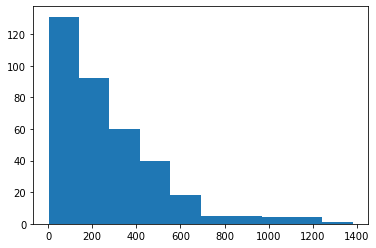

In [20]:
# MAE 분포 확인
MAS = pred_test_df.select('AE').collect()
AES_MAES = [AE[0] for AE in MAS]
plt.hist(AES_MAES)

In [21]:
train_df = (
    df
    .select(col('dt').alias('ds'), col('Global_active_power').alias('y_test'))
    .where('dt <= "{}"'.format(cutoff))
).toPandas()

In [22]:
pred_test_df = pred_test_df.toPandas()
pred_test_df = pred_test_df.set_index('ds')
train_df.index = pd.to_datetime(train_df.index)
pred_test_df.index = pd.to_datetime(pred_test_df.index)

In [23]:
# z-score 3보다 크면 이상치 
pred_test_df['ae_zscore'] = (pred_test_df['AE'] - pred_test_df['AE'].mean()) / pred_test_df['AE'].std()
threshold = 3
abnormal = pred_test_df[pred_test_df['ae_zscore'] > threshold] 
abnormal

,yhat,y_test,AE,ae_zscore
ds,,,,
2009-12-20,2313.204810,1144.166,1169.038810,3.780170
2010-01-02,2383.509147,1309.268,1074.241147,3.381372
2010-03-06,1817.053188,794.712,1022.341188,3.163038
2010-03-08,1469.002083,2557.098,1088.095917,3.439657
2010-08-27,888.593571,2030.650,1142.056429,3.666660
2010-10-18,1484.441856,2713.884,1229.442144,4.034276
2010-11-04,1375.577692,2555.146,1179.568308,3.824466
2010-11-21,2282.941840,900.910,1382.031840,4.676195


In [24]:
train_df = train_df.set_index('ds')

In [25]:
train_df.index = pd.to_datetime(train_df.index)

Text(0.5, 0.98, 'Forecast - Results | Test MAE = 270.4598')

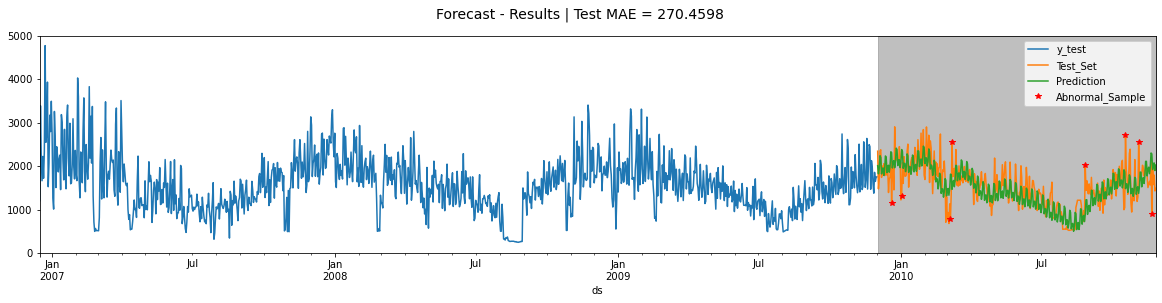

In [26]:
# 시각화
fig, axes = plt.subplots(ncols=1, figsize=(20, 4))
train_df.plot(ax=axes, label='Train_set')
pred_test_df['y_test'].plot(ax=axes, label='Test_Set')
pred_test_df['yhat'].plot(ax=axes, label='Prediction')
abnormal['y_test'].plot(ax=axes, style='r*', label='Abnormal_Sample')
axes.set_ylim(0, 5000)
axes.fill_between(x=pred_test_df.index, 
                     y1=0, y2=5000,
                     color='grey', alpha=.5)
plt.legend()
fig.suptitle('Forecast - Results | Test MAE = {:.4f}'.format(MAE_value), fontsize=14)